# **Machine Learning Final Project: Airline Satisfaction Classification**  
  


**Name:** Anish Kurani

**Utils**

In [1]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
satisfaction_df = pd.read_csv('airline_passenger_satisfaction.csv') # load the airline satisfaction data as a pandas dataframe

In [3]:
satisfaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [4]:
satisfaction_df.describe()

,ID,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
count,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,64940.500000,39.427957,1190.316392,14.713713,15.091129,3.057599,2.756876,3.306267,3.252633,2.976925,3.383023,3.441361,3.350878,3.286326,3.204774,3.642193,2.728696,3.358077,3.632114
std,37493.270818,15.119360,997.452477,38.071126,38.465650,1.526741,1.401740,1.266185,1.350719,1.278520,1.287099,1.319289,1.316252,1.313682,1.329933,1.176669,1.329340,1.334049,1.180025
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,32470.750000,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000
50%,64940.500000,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000
75%,97410.250000,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000
max,129880.000000,85.000000,4983.000000,1592.000000,1584.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


**Visualization**

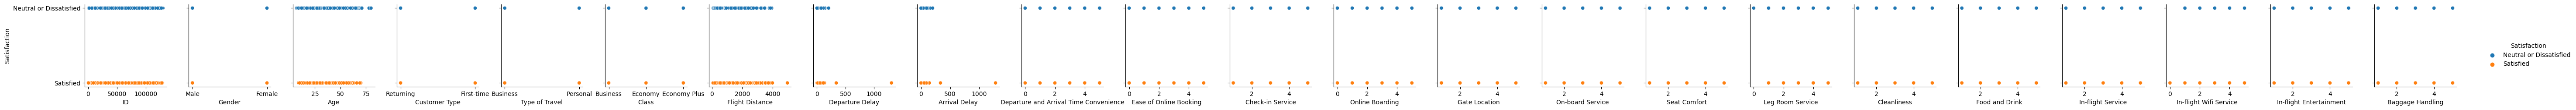

In [5]:
import seaborn as sns
rng = np.random.RandomState(0)
indices = rng.choice(np.arange(len(satisfaction_df)), size=500, replace=False)
sns.pairplot(
    data=satisfaction_df.iloc[indices],
    y_vars='Satisfaction',
    x_vars=list(satisfaction_df.drop('Satisfaction',axis=1).columns),
    hue="Satisfaction",
)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

def add_bias(X: np.ndarray) -> np.ndarray:
    
    bias = np.ones((X.shape[0], 1))
    
    return np.hstack((bias, X))

def get_preprocessed_data() -> Tuple[np.ndarray, ...]:
    """ Gets preprocessed data for training, validation, and testing

        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst= None, None, None, None, None, None

    categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class'] # Set the categorical features
    numerical_columns = ['Age', 'Flight Distance', 'Departure Delay', 'Arrival Delay'] + [ # Set the numerical columns
        col for col in satisfaction_df.columns if "Service" in col or "Convenience" in col
    ]
    
    satisfaction_df['Arrival Delay'].fillna(satisfaction_df['Arrival Delay'].median(), inplace=True) # Fill in missing data in feature
    
    X = satisfaction_df.drop(columns=['ID', 'Satisfaction']) # Drop ID (not relavent) and Satisfaction (y)
    y = satisfaction_df['Satisfaction'].map({'Neutral or Dissatisfied': 0, 'Satisfied': 1}).values # Map classes to 0 and 1

    preprocessor = ColumnTransformer( # Preprocess data using preprocessor transformer
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            #('cat', OneHotEncoder(sparse_output=False), categorical_columns) # no need to encode
        ]
    )
    
    X_preprocessed = preprocessor.fit_transform(X)
    
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X_preprocessed, y)
    
    X_trn = add_bias(X=X_trn)
    X_vld = add_bias(X=X_vld)
    X_tst = add_bias(X=X_tst)

    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [8]:
def plot_line_decision_boundary(
    X: np.ndarray, 
    y: np.ndarray,
    w: np.ndarray,
    xlabel: str = '',
    ylabel: str = '',
    includes_bias:bool = False,
    class_names: dict = None
):
    if len(w) > 3:
        raise ValueError("To plot boundary requires at most 3 weights")
        
    # Create decision boundary
    line_X = np.linspace(np.min(X[:, 1])-1, np.max(X[:, 1])+1, len(X)).reshape(-1,1)
    slope = -(w[0] / w[2]) / (w[0] / w[1])
    y_intercept = -w[0]/ w[2]
    decision_boundry = slope * line_X + y_intercept
    
    # plot data
    plot_2D_data(
        X, 
        y,
        xlabel=xlabel,
        ylabel=ylabel,
        includes_bias=includes_bias, 
        class_names=class_names)
    
    plt.plot(line_X, decision_boundry)
    plt.ylim(np.min(X[:, 2])-1, np.max(X[:, 2])+1)
    plt.xlim(np.min(X[:, 1])-1, np.max(X[:, 1])+1)
    plt.legend()
    
def plot_2D_data(
    X: np.ndarray, 
    y: np.ndarray,
    xlabel: str = '',
    ylabel: str = '',
    includes_bias=False, 
    class_names=None
):
            
    class_labels = np.unique(y)
    
    if class_names is None:
        class_names = {l:f"class {i+1}" for i, l in enumerate(class_labels)}

    if includes_bias:
        col_1, col_2 = 1, 2
    else:
        col_1, col_2 = 0, 1
    
    for l in class_labels:
        class_locs = np.where(y == l)[0]
        class_X = X[class_locs]
        class_name = class_names.get(l, f'class {l}')

        plt.scatter(class_X[:, col_1],
                    class_X[:, col_2], 
                    label=class_name)

    # Plot data
    plt.xlim([np.min(X[:, col_1])-.5, np.max(X[:, col_1])+.5])
    plt.ylim([np.min(X[:, col_2])-.5, np.max(X[:, col_2])+.5])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

In [9]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

In [10]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_names: Dictionary mapping labels to class names.

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True, fmt='g')
    plt.show()
    return cfm_df

In [11]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    
    return np.exp(z) / (1 + np.exp(z))

In [12]:
def nll_loss(y: np.ndarray, probs: np.ndarray) -> float:
    """ Computes the average generalized NLL Loss

        Args:
            y: The ground truth one-hot encoded labels
                given as matrix of shape (M, |K|).

            probs: The predicted probabilities for the
                corresponding labels given as a matrix
                of shape (M, |K|)
    """
    
    return (-1 / y.shape[0]) * np.sum(y * np.log(probs))

In [13]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

# **Algorithm 1: Logistic Regression**

In [14]:
class LogisticRegression:
    """ Performs logistic regression using gradient descent
    
        Attributes:

            alpha: learning rate or step size.
                
            batch_size: Size of mini-batches for mini-batch gradient
                descent.
            
            epochs: Number of epochs to run for mini-batch
                gradient descent.
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            W: Matrix of weights with shape (N, |K|) 

            trn_loss: Stores the training loss for each epoch.

            vld_loss: Stores the validation loss for each epoch.
    """
    def __init__(
        self, 
        alpha: float,
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        
        self.W = None
        self.trn_loss = None
        self.vld_loss = None
    
    def fit(
         self, 
         X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        """
            Args:
                X: Training features/data
                y: Training labels
                X_vld: Validation features/data
                y_vld: Validation labels
                seed: Seed used for initializing weights
        """
        # Set seed for reproducibility
        np.random.seed(self.seed)
        # Track training/validation loss
        self.trn_loss = []
        self.vld_loss = []
        
        # Randomly initialize weights
        
        self.W = np.random.rand(X.shape[1], 1)
        
        for e in range(self.epochs):
            
            batches = get_batches(data_len=X.shape[0], batch_size=self.batch_size)
            
            for b in batches:
                
                Z = X[b] @ self.W
                
                y_probs = sigmoid(Z)
                
                self.W -= self.alpha * ((1 / len(b)) * (X[b].T @ (y_probs - y[b])))
            
            self.trn_loss.append(nll_loss(y, sigmoid(X @ self.W)))
            
            if X_vld is not None and y_vld is not None:
                
                self.vld_loss.append(nll_loss(y_vld,  sigmoid(X_vld @ self.W)))
        
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        return np.uint8((sigmoid(X @ self.W) > 0.5).reshape(-1, 1)) # return class (not probabilities)

Training Accuracy: 0.7770773432142728


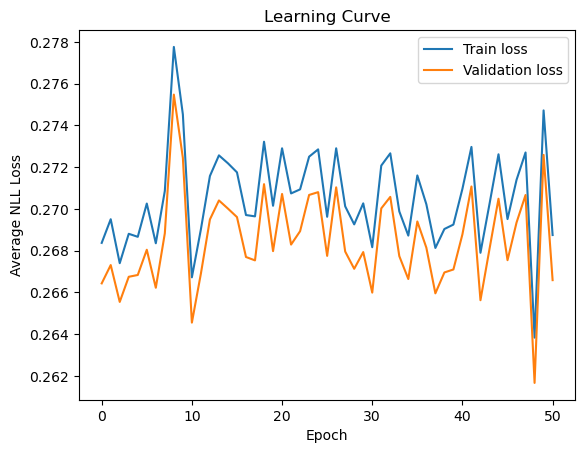

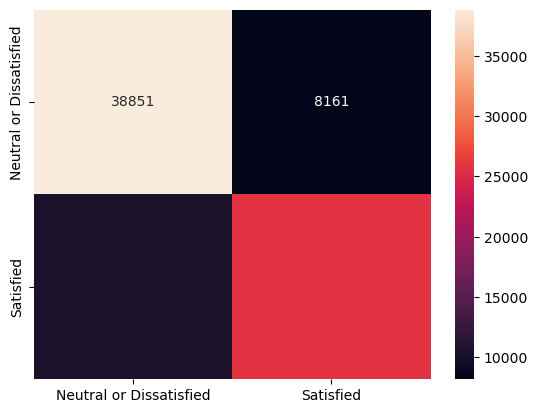

,Neutral or Dissatisfied,Satisfied
Neutral or Dissatisfied,38851,8161
Satisfied,10369,25742


In [15]:
class_names = { False : 'Neutral or Dissatisfied', True : 'Satisfied'}

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

lr = LogisticRegression(
    alpha=0.03,
    batch_size=64,
    epochs=51,
    seed=0
)

lr.fit(X_trn, y_trn, X_vld, y_vld)

y_hat_trn = lr.predict(X_trn)

print('Training Accuracy:', accuracy_score(y_true=y_trn.flatten(), y_pred=y_hat_trn.flatten()))

### LEARNING CURVE ###

plt.plot(lr.trn_loss, label='Train loss')
plt.plot(lr.vld_loss, label='Validation loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


#plot_line_decision_boundary(X_trn, y_trn, lr.trn_loss, includes_bias=True)

plot_confusion_matrix(y=y_trn.flatten(), y_hat=y_hat_trn.flatten(), class_names=class_names)

Validation Accuracy: 0.7820605360665993


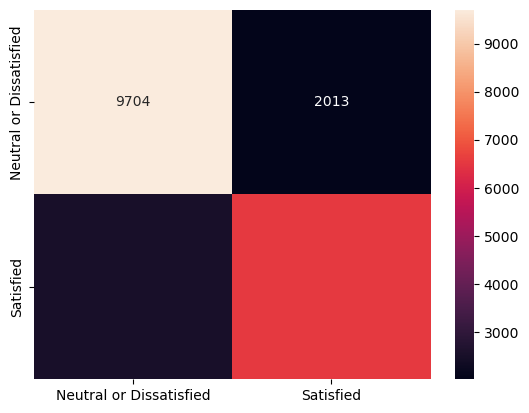

,Neutral or Dissatisfied,Satisfied
Neutral or Dissatisfied,9704,2013
Satisfied,2516,6548


In [16]:
y_hat_vld = lr.predict(X_vld)

print('Validation Accuracy:', accuracy_score(y_true=y_vld.flatten(), y_pred=y_hat_vld.flatten()))

plot_confusion_matrix(y=y_vld.flatten(), y_hat=y_hat_vld.flatten(), class_names=class_names)

Testing Accuracy: 0.77594702802587


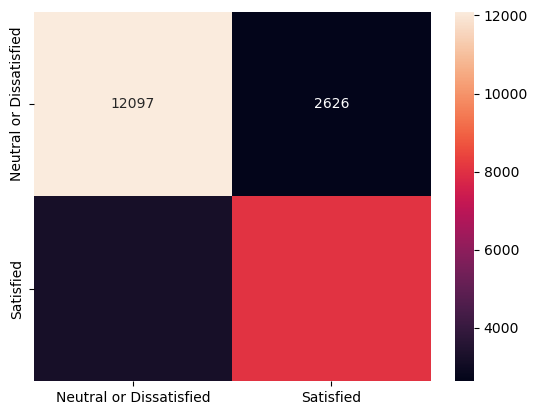

,Neutral or Dissatisfied,Satisfied
Neutral or Dissatisfied,12097,2626
Satisfied,3194,8059


In [17]:
y_hat_tst = lr.predict(X_tst)

print('Testing Accuracy:', accuracy_score(y_true=y_tst.flatten(), y_pred=y_hat_tst.flatten()))

plot_confusion_matrix(y=y_tst.flatten(), y_hat=y_hat_tst.flatten(), class_names=class_names)

# **Algorithm 2: Neural Network**

In [18]:
# !pip install tensorflow

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout

class TensorFlowNeuralNetwork(tf.keras.Model):
    
    def __init__(self, use_dropout=True, seed=0):
        tf.keras.backend.clear_session()
        tf.random.set_seed(seed)
        
        super().__init__()
        
        self.use_dropout = use_dropout
        
        self.hidden_layer1 = Dense(
            units=16, 
            activation=tf.keras.activations.relu, 
            kernel_initializer=tf.keras.initializers.HeUniform(),
            name="hidden_layer_1"
        )
        
        if self.use_dropout:
            self.dropout1 = Dropout(
                rate=0.20,
                name="dropout1"
            )
            
        self.hidden_layer2 = Dense(
            units=8, 
            activation=tf.keras.activations.relu, 
            kernel_initializer=tf.keras.initializers.HeUniform(),
            name="hidden_layer_2"
        )
        
        if self.use_dropout:
            self.dropout2 = Dropout(
                rate=0.20,
                name="dropout2"
            )
            
        self.hidden_layer3 = Dense(
            units=4, 
            activation=tf.keras.activations.relu, 
            kernel_initializer=tf.keras.initializers.HeUniform(),
            name="hidden_layer_3"
        )
        
        if self.use_dropout:
            self.dropout3 = Dropout(
                rate=0.20,
                name="dropout3"
            )
            
        self.output_layer = Dense(
            units=1, 
            activation=tf.keras.activations.sigmoid, 
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            name="output_layer"
        )

    def call(self, X, training):
        A1 = self.hidden_layer1(X)
        
        if self.use_dropout :
            A1 = self.dropout1(A1, training=training)
            
        A2 = self.hidden_layer2(A1)
        
        if self.use_dropout :
            A2 = self.dropout2(A2, training=training)
            
        A3 = self.hidden_layer3(A2)
        
        if self.use_dropout :
            A3 = self.dropout3(A3, training=training)
            
        y_hat_probs = self.output_layer(A3)
        return y_hat_probs

In [19]:
tf_nn = TensorFlowNeuralNetwork(use_dropout=False, seed=0)

tf_nn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics=['accuracy']
)

hist = tf_nn.fit(
    x=X_trn, 
    y=y_trn, 
    validation_data=(X_vld, y_vld), 
    batch_size=64, 
    epochs=51
)


Epoch 1/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8404 - loss: 0.3576 - val_accuracy: 0.8826 - val_loss: 0.2632
Epoch 2/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.8829 - loss: 0.2652 - val_accuracy: 0.8894 - val_loss: 0.2496
Epoch 3/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.8864 - loss: 0.2565 - val_accuracy: 0.8871 - val_loss: 0.2529
Epoch 4/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.8851 - loss: 0.2546 - val_accuracy: 0.8915 - val_loss: 0.2454
Epoch 5/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.8892 - loss: 0.2520 - val_accuracy: 0.8876 - val_loss: 0.2499
Epoch 6/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8882 - loss: 0.2509 - val_accuracy: 0.8869 - val_loss: 0.2508
Epoch 7/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8889 - loss: 0.2512 - val_accuracy: 0.8920 - val_loss: 0.2407
Epoch 8/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.8903 - loss

Epoch 49/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.8956 - loss: 0.2416 - val_accuracy: 0.8922 - val_loss: 0.2412
Epoch 50/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.8957 - loss: 0.2419 - val_accuracy: 0.8954 - val_loss: 0.2391
Epoch 51/51
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.8947 - loss: 0.2427 - val_accuracy: 0.8931 - val_loss: 0.2408


2598/2598 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step


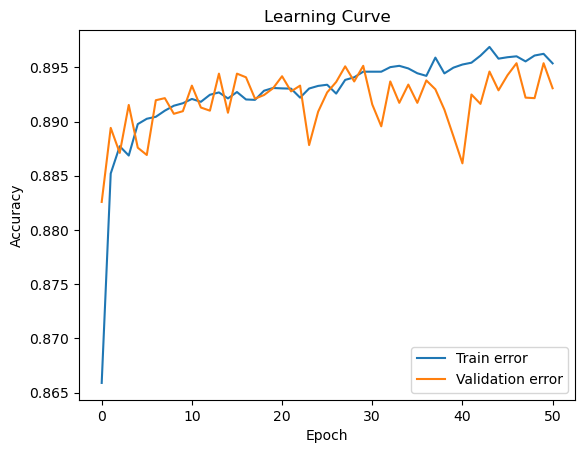

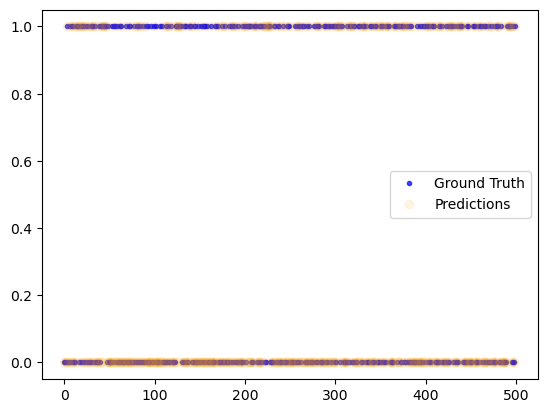

Train Accuracy: 0.8941207608002598


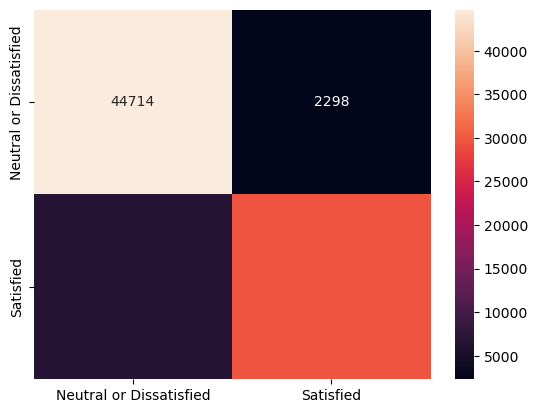

,Neutral or Dissatisfied,Satisfied
Neutral or Dissatisfied,44714,2298
Satisfied,6503,29608


In [20]:
y_hat_trn_prob = tf_nn.predict(X_trn)
y_hat_trn = (y_hat_trn_prob > 0.5).astype(int)

### PLOTS LEARNING CURVE ###

plt.plot(hist.history['accuracy'], label='Train error')
plt.plot(hist.history['val_accuracy'], label='Validation error')
plt.title("Learning Curve")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(y_trn[:500], '.', label='Ground Truth', color='blue', alpha=0.70)
plt.plot(y_hat_trn[:500], 'o', label='Predictions', color='orange', alpha=0.1)
plt.legend()
plt.show()

print('Train Accuracy:', accuracy_score(y_true=y_trn.flatten(), y_pred=y_hat_trn.flatten()))

plot_confusion_matrix(y=y_trn.flatten(), y_hat=y_hat_trn.flatten(), class_names=class_names)

650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
Validation Accuracy: 0.893075405418411


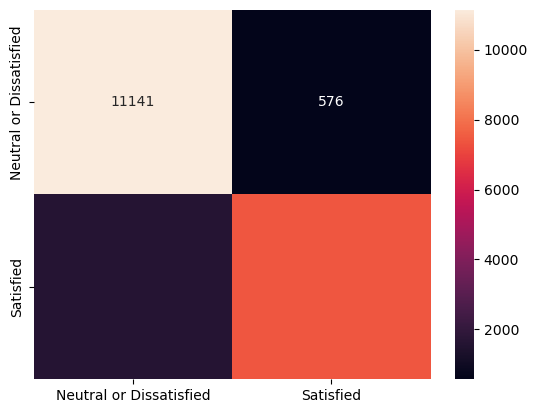

,Neutral or Dissatisfied,Satisfied
Neutral or Dissatisfied,11141,576
Satisfied,1646,7418


In [21]:
y_hat_vld_prob = tf_nn.predict(X_vld)
y_hat_vld = (y_hat_vld_prob > 0.5).astype(int)

print('Validation Accuracy:', accuracy_score(y_true=y_vld.flatten(), y_pred=y_hat_vld.flatten()))

plot_confusion_matrix(y=y_vld.flatten(), y_hat=y_hat_vld.flatten(), class_names=class_names)

812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
Testing Accuracy: 0.8913227594702803


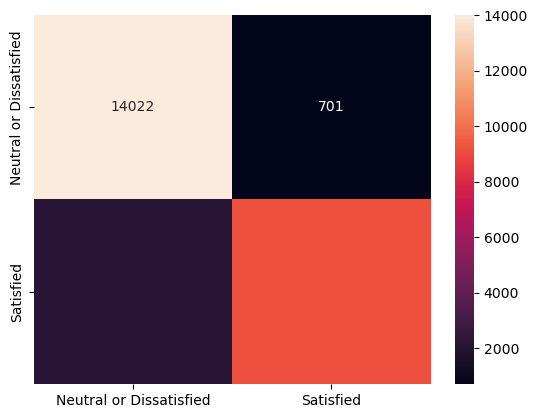

,Neutral or Dissatisfied,Satisfied
Neutral or Dissatisfied,14022,701
Satisfied,2122,9131


In [22]:
# loss, tst_acc = tf_nn.evaluate(X_tst, y_tst)

y_hat_tst_prob = tf_nn.predict(X_tst)
y_hat_tst = (y_hat_tst_prob > 0.5).astype(int)

print('Testing Accuracy:', accuracy_score(y_true=y_tst.flatten(), y_pred=y_hat_tst.flatten()))

plot_confusion_matrix(y=y_tst.flatten(), y_hat=y_hat_tst.flatten(), class_names=class_names)